# HMM to estimate Funnel position

## Import libraries and constants

In [1]:
import matplotlib.pyplot as plt

import config.CONSTANTS_HMM as consts

# Project libraries
import src.hmm_package.generate_hmm
from src.hmm_package.generate_hmm import *
from src.plot_and_print_info.plots_and_print_info import *

# Built in libraries
import numpy as np
import importlib

In [9]:
importlib.reload(src.hmm_package.generate_hmm)
from src.hmm_package.generate_hmm import *
importlib.reload(consts)
from config.CONSTANTS_HMM import *

In [3]:
# Store constants
cm = {}
for k, v in consts.__dict__.items():
    if not k.startswith('__'):
        cm[k] = v

## Compute Observation and Adstock

To study the behaviour of the Hidden Markov Model, we generate a random exposition of the users to some campaigns. The parameters for the simulation are in config/CONSTANTS_HMM.py

In [4]:
# Generate Test observation
observation = simulate_observations(cm)

# Compute Adstock
adstock = compute_adstock(cm, observation=observation)

2022-06-18 10:46:39.596087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Real HMM to Estimate

In [5]:
# Generate the distributions to build the Real HMM.
# The parameter MU, describing the behaviour of a user unexposed, has been fitted in a separate notebook and is considered known.
#NB The variable STATES_ARE_OBSERVABLE is set in config/execution_parameters.
hmm_distributions = generate_hmm_distributions(cm, initial_state_prob_vector= INITIAL_STATE_PROB,
                                               click_prob=tf.constant(CLICK_PROB),
                                               adstock=adstock)

# Create Real HMM to fit
real_hmm = tfd.HiddenMarkovModel(
    initial_distribution=hmm_distributions['initial_distribution'],
    transition_distribution=hmm_distributions['transition_distribution'],
    observation_distribution=hmm_distributions['observation_distribution'],
    time_varying_transition_distribution=True,
    num_steps=time+1
)

# Sample emissions
emission_real = real_hmm.sample().numpy()

In [6]:
emission_real

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

### Visualize the Real HMM

Percentage of conversion is: 0.1754%.


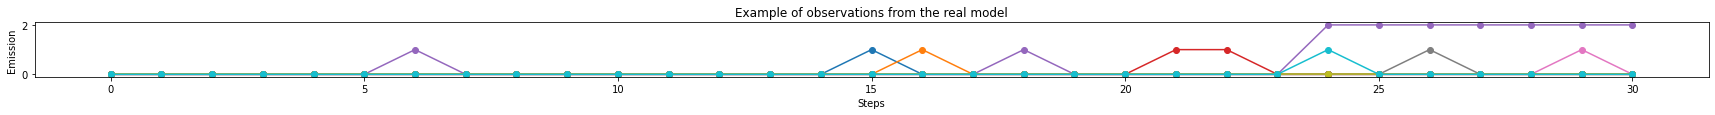

In [7]:
# Count conversions from sampled data
# We aim to see a conversion rate around 20/25%.

tot_conversions = count_conversions(emission_real)
plot_sample_emissions(real_hmm)

## Fit model with real parameter for Sanity Check

In [10]:
# STATES_ARE_OBSERVABLE is defined in CONSTANTS_HMM
# The initializer here is the true parameter. The goal is to compute the optimal loss, and see whether the parameters move away from the optimum.
initializer={
    'BETA': tf.keras.initializers.Constant(BETA),
    'INIT_PROB': tf.keras.initializers.Constant(INITIAL_STATE_PROB),
    'CLICK_PROB': tf.keras.initializers.RandomNormal(CLICK_PROB)},
model_test = build_hmm_to_fit_beta(cm, mu=MU, initializer=initializer)

compiler = CompilerInfoBeta(cm, LR_EXPONENTIAL_DECAY)
model_test.compile(
    loss = compiler.loss,
    optimizer = compiler.optimizer,
    run_eagerly = True
)
BETA = [0.7, -0.3, 0.15, 0.4, -0.4, 0.8]
history = fit_model(cm, model_test, adstock, emission_real)

Mu: [-2.0, -1.0, -4.0] Beta: [0.75, -0.6, 0.1, 0.3, -0.4, 0.5, 0.1, -0.5, 0.9, 0.0, -0.1, 0.1] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.7109495>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.557822>]
Epoch 1/200


2022-06-18 10:48:15.252578: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ValueError: Cannot assign value to variable ' transition_prob_layer_beta_1/Beta:0': Shape mismatch.The variable shape (12,), and the assigned value shape (9,) are incompatible.

[0.7, -0.3, 0.15, 0.4, -0.4, 0.8]

In [ ]:
save_result(model_test, adstock, emission_real, initializer)

In [9]:
plt.plot(model_test.history.epoch, model_test.history.history['loss'])

NameError: name 'model_test' is not defined

As you can see above, the parameters slightly change, although the loss remains the same. Below, you can see the average difference for each transition and each user.

In [ ]:
matrix_diff = lambda usr: tf.reduce_sum(make_transition_matrix(cm, MU, model_test.weights[0], adstock[usr:usr+1]) - make_transition_matrix(cm, MU,BETA, adstock[usr:usr+1]), axis=1)/30
avg_diff = sum(matrix_diff(usr) for usr in range(N_users))/N_users

## Build and fit the model starting from a random initializer

In [29]:
inverse_sigmoid = lambda x: np.log(x/(1-x))
# Now try to fit the model sampled from the real parameters.
initializer={
    'BETA': tf.keras.initializers.Constant([ 1., 0., 0., 0., 0., 1.]),
    'INIT_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.75)), #
    'CLICK_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.25))},
model = build_hmm_to_fit_beta(cm, mu=MU, initializer=initializer )

compiler = CompilerInfoBeta(cm, LR_EXPONENTIAL_DECAY)
model.compile(
    loss = compiler.loss,
    optimizer = compiler.optimizer,
    run_eagerly = True
)
MU = [ -2.7419195, -1.1010361, -5.92728  ]
BETA = [0.7, -0.3, 0.15, 0.4, -0.4, 0.8]
history = fit_model(cm, model, adstock, emission_real)
save_result(cm, model, adstock, emission_real, initializer)


Mu: [-2.0, -1.0, -4.0] Beta: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.75>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.25000003>]
Epoch 1/200
40/40 [==============================] - 15s 372ms/step - loss: 5917.6343
Mu: [-2.0386586, -0.9611387, -4.0393357] Beta: [0.9611767, 0.0, -0.0, -0.0, 0.0, 0.9607115] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.7570575>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.2435967>]
Epoch 2/200
40/40 [==============================] - 14s 350ms/step - loss: 5862.7031
Mu: [-2.0720928, -0.9269671, -4.075932] Beta: [0.9272661, 0.0, -0.0, -0.0, 0.0, 0.924247] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.763723>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.24102667>]
Epoch 3/200
40/40 [==============================] - 14s 360ms/step - loss: 5823.5254
Mu: [-2.099555, -0.89798564, -4.1093597] Beta: [0.89881, 0.0, -0.0, -0.0, 0.0, 0.89113766] Init Pro

ValueError: This test already exists in hmm_test_fitting.data!

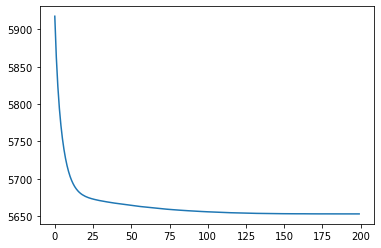

In [30]:
plt.plot(model.history.epoch, model.history.history['loss'])

In [34]:
print([el for el in a.keys()])

['N Users:20000,\n Epochs: 200,\n Learning rate: LR: Constant, value=0.001']


NameError: name 'tf' is not defined

Supponiamo che il vettore fittato dal modello sia: #camp1: [ 0.8700186 ,  0.29879373, -0.35601237,  0.14475204,                                                     #camp2:   0.32184145,  0.06852179, -0.33719164,  0.80015075]
Dal punto di vista teorico, i valori sono in linea con quelli sperati. Per interpetare i parametri, si tenga conto che: abbiamo 8 valori, di cui 4 per campagna: per ogni campagna il parametro 0 è l’influenza della campagna a passare da stato 0->1, il parametro 1 è l’influenza 0->2, il terzo è l’influenza 1->0 (quindi ci aspettiamo che sia negativo), e il quarto è l'influenza 1->2.
Se compariamo i valori, partendo dalla tupla reale, l’obiettivo è osservare che la prima campagna influenzi il passaggio da stato 0 a stato 1 più della seconda campagna, mentre la seconda campagna dovrebbe avere l’effetto opposto, ovvero di influenzare più il passaggio da stato 1 a conversione.
Dai valori dei parametri fittati partendo da inizializzazione di zeri, osserviamo alcune cose:
1) Alcuni valori sembrano essere stati fittati correttamente. In particolare i valori di transizione da stato 1->2, ovvero 0.15 e 0.8.
2) Gli altri pesi attribuiti sono coerenti con quelli reali. La campagna 1 mostra influenze piu alte nello stato zero (peso transizione 0->1 = 0.87, 0->2 = 0.3) rispetto alla campagna 2 (peso transizione 0->1 = 0.32, 0->2 = 0.07), mentre la campagna due mostra peso di transizione da stato intermedio a conversione più alto (1->2 = 0.8, vs campagna 1: 1->2 = 0.14). Pertanto, seppur i valori non siano esattamente quelli reali, viene catturata l'idea di avere campagne con influenze diverse in stati diversi, principale obiettivo del problema di attribution.
3) Nel caso di sanity check partendo da parametri esatti, si è osservato che il vettore cambia nonostante la loss rimanga costante. Il vettore fittato da inizializzazione di zeri, sembrerebbe avvicinarsi a questa versione modificata del vettore reale. Comprendere per quale motivo ci si discosta dal vettore reale forse permetterebbe di risolvere questa discrepanza.

Sotto, osserviamo anche la differenza media tra matrici di transizione ottenute con i parametri reali e quelli fittati dal modello.

In [ ]:
load_results()
matrix_diff = lambda usr: tf.reduce_sum(make_transition_matrix(cm, MU, model_test.weights[0], adstock[usr:usr+1]) - make_transition_matrix(cm, MU,BETA, adstock[usr:usr+1]), axis=1)/30
avg_diff = sum(matrix_diff(usr) for usr in range(N_users))/N_users